# An Intro To Probablistic Programming

Probablistic programming is an expressive and flexible way to build Bayesian statistical models in code.  It's an entirely different mode of programming that involves using non-deterministic variables defined using probability distributions instead of concrete values.  Probablistic programming is gaining significant traction as a paradigm for building next-generation intelligent systems.  In this notebook we'll apply bayesian methods to solve a few simple problems to illustrate the power probablistic programming.  For this exercise we'll be using PyMC3.

(NOTE: This notebook is partially adapted from the PyMC3 "Getting Started" tutorial at https://pymc-devs.github.io/pymc3/getting_started/. PyMC3 is currently considered beta software and should be treated as such.)

For our first exercise we're going to implement multiple linear regression using a very simple two-variable dataset that I'm borrowing from an exercise I did for a machine learning course.  Let's load up and visualize the data.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# running this one on Linux so using Linux paths
path = os.getcwd() + '/data/ex1data2.txt'
data = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
data.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


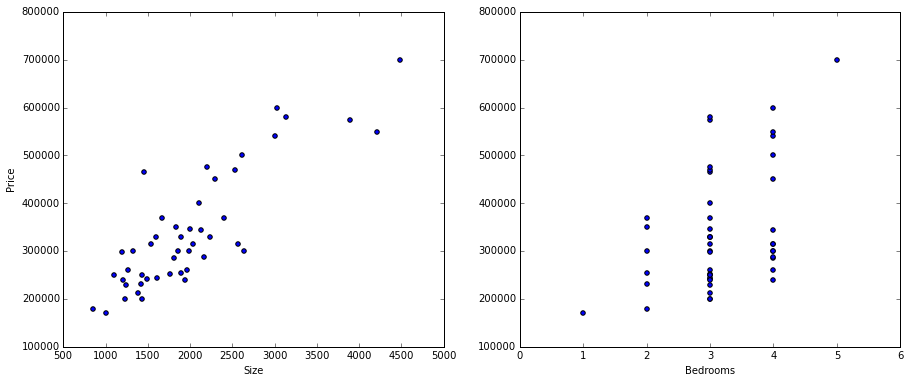

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].scatter(data.Size, data.Price)
ax[1].scatter(data.Bedrooms, data.Price)
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Size')
ax[1].set_xlabel('Bedrooms')

We also need a baseline technique to compare to the bayesian approach so we have an idea of how well it's performing.  For that we'll load up scikit-learn's linear regression module.  We'll use squared error to evaluate the performance.

In [3]:
from sklearn import linear_model
model = linear_model.LinearRegression()

# normalize features
data = (data - data.mean()) / data.std()

X = data[['Size', 'Bedrooms']].values
y = data['Price'].values

model.fit(X, y)
y_pred = model.predict(X)
squared_error = ((y - y_pred) ** 2).sum()
squared_error

12.284529170669948

For fun let's see what parameters it came up with too.  We can also compare these later on.

In [4]:
model.intercept_, model.coef_

(-1.2033011196250568e-16, array([ 0.88476599, -0.05317882]))

Okay, now we're ready to proceed.  In order to define our model in PyMC3, we need to frame the problem in bayesian terms.  This is no small task for a beginner in bayesian statistics and takes some getting used to.  In the case of linear regression, we're interested in predicting outcomes Y as normally-distributed observations with an expected value μ that is a linear function of two predictor variables, X1 and X2.  Using this model, μ is our expected value, alpha is our intercept, beta is an array of coefficients, and sigma represents the observation error.  Since these are all unknown, non-deterministic variables, we need to specify a prior to instantiate them.  We'll use normal distributions with a mean of zero.

In [5]:
from pymc3 import Model, Normal, HalfNormal

regression_model = Model()
with regression_model:
    # priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # expected value of outcome
    mu = alpha + beta[0] * X[:,0] + beta[1] * X[:,1]

    # likelihood (sampling distribution) of observations
    y_obs = Normal('y_obs', mu=mu, sd=sigma, observed=y)

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 460


Note that each variable is either declared with a prior representing the distribution of that variable, or (in the case of μ) is a deterministic outcome of other stochastic variables.  Also of note is the y_obs variable, which is a special type of "observed" variable that represents the data likelihood of the model.  Finally, observe that we're mixing PyMC variables with the variables holding the data.  PyMC's models are very expressive and we could use a variety of mathematical functions to define our variables.

Now that we've specified our model, we need to obtain posterior estimates for the unknown variables in the model.  There are two techniques we can leverage for this and they can be used to complement each other.  The first thing we're going to do is find the <b>Maximum A Priori Estimate (MAP)</b> for the model.  The MAP is a point estimate for the model parameters obtained using numerical optimization methods.

In [6]:
from pymc3 import find_MAP
from scipy import optimize

map_estimate = find_MAP(model=regression_model, fmin=optimize.fmin_powell)
print(map_estimate)

{'alpha': array(3.396023412944341e-09), 'beta': array([ 0.8846891, -0.0531327]), 'sigma_log': array(-0.6630286280877248)}


In this case we're overriding the default optimization algorithm (BFGS) and specifying our own, but we could have left it as the default too.  Any optimization algorithm that minimizes the loss on the objective function should work.

Finding the MAP is a good starting point but it's not necessarily the best answer we can find.  To do that, we need to use a simulation-based approach such as Markov Chain Monte Carlo (MCMC).  PyMC3 implements a variety of MCMC sampling algorithms including the No-U-Turn Sampler (NUTS), which is especially good for models that have many continuous variables because it uses gradient-based techniques to converge much faster than traditional sampling algorithms.

Let's use the MAP as a starting point and sample the posterior distribution 1000 times using MCMC.

In [7]:
from pymc3 import NUTS, sample

with regression_model:
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw posterior samples
    trace = sample(5000, step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 11.4 sec

/home/john/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


We can examine the trace object directly to see the sampled values for each of the variables in the model.

In [8]:
trace['alpha'][-5:]

array([ 0.07095636, -0.05955168,  0.09537584,  0.04383463,  0.10311347])

Although the flexibility to inspect the values directly is useful, PyMC3 provides plotting and summarization functions for inspecting the sampling output that tell us much more at a glance. A simple posterior plot can be created using traceplot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb46b261a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb4634a9f10>]], dtype=object)

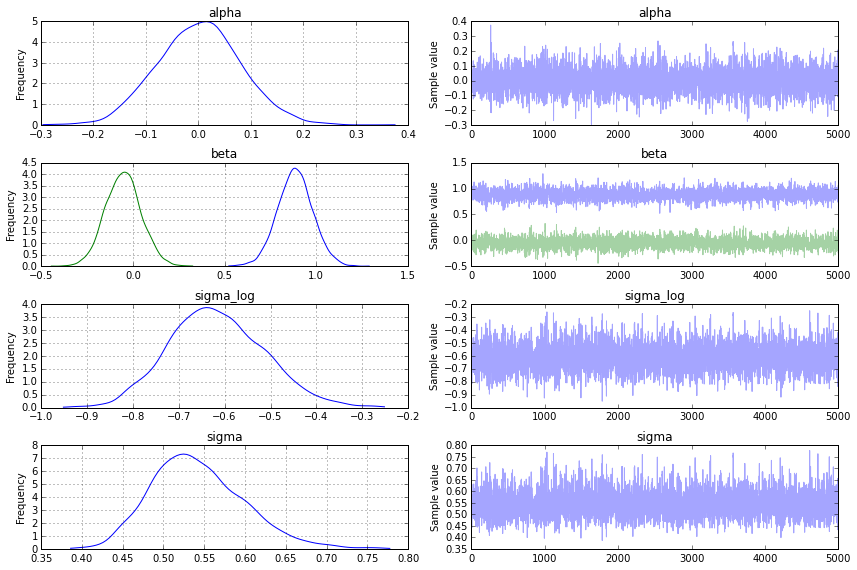

In [9]:
from pymc3 import traceplot
traceplot(trace)

There's also a text-based output available using the summary function.

In [10]:
from pymc3 import summary
summary(trace)


alpha:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.002            0.080            0.001            [-0.154, 0.157]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.152         -0.051         0.003          0.055          0.162


beta:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.884            0.096            0.002            [0.688, 1.063]
  -0.052           0.097            0.002            [-0.237, 0.139]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.697          0.821          0.884          0.946          1.076
  -0.237         -0.118         -0.0

So we now have posterior distributions for each of our model parameters, but what do we do with them?  Remember our original task was to find a model that minimizes the squared error of the training data.  We've created a probablistic model of the parameters in the linear regression model, but we need to use point values to calculate the squared error.  The most straightforward approach would be to use the mean, or expected value, of the parameters and plug those into the linear regression equation.  Let's try that.

In [11]:
# so we can use vector math to compute the predictions at once
data.insert(0, 'Ones', 1)

X = data.iloc[:, 0:3].values
params = np.array([0, 0.883, -0.052])
y_pred = np.dot(X, params.T)

bayes_squared_error = ((y - y_pred) ** 2).sum()
bayes_squared_error

12.284629306712745

Total squared error probably isn't the best way to evaluate the performance of a model.  In a real scenario we'd be testing predictions on unseen data, testing the robustness of the model, etc.  But it's still pretty interesting that the parameter means it found resulted in a model with basically the exact same squared error as the scikit-learn linear regression model.  Fascinating stuff.

Since linear models are pretty common, PyMC3 also has a GLM module that makes specifying models in this format much easier.  It uses patsy to define model equations as a string (similar to R-style formulas) and creates the necessary variables underneath.

In [12]:
from pymc3 import glm

with Model() as model:
    glm.glm('Price ~ Size + Bedrooms', data)
    start = find_MAP()
    step = NUTS(scaling=start)
    trace = sample(5000, step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 12.4 sec

The end result should look pretty similar to the trace that we obtained from the first example.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb490ba8090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb43b585190>]], dtype=object)

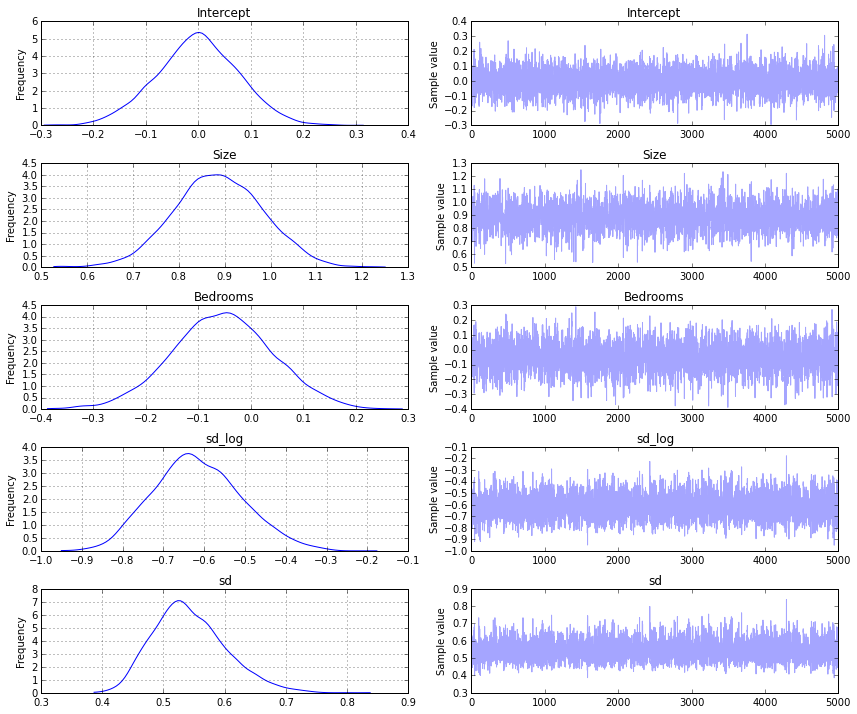

In [13]:
traceplot(trace)

So that's what bayesian inference looks like when applied to multiple linear regression.  At this point it's worth asking - how would one use this in the broader picture, especially on non-trivial problems?  For someone interested primarily in machine learning applications (vs. scientific analysis), where does this fit in the toolbox?  These are questions that I'm still figuring out.  I think the real power of bayesian modeling comes from incorporating domain knowledge into graphical models such as what Daphne Koller teaches in her <a href="https://www.coursera.org/course/pgm">Probablistic Graphical Models</a> class.  I hope to explore this further in a future notebook and attempt to apply it to a real machine learning problem.